In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
from matplotlib import pyplot as plt
import dvu
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import viz
import numpy as np
import torch
import scipy
from matplotlib import pyplot as plt
from sklearn import metrics
import data
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from copy import deepcopy
import config
import models
import pandas as pd
import features
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.svm import SVR
from collections import defaultdict

# compare all different models across dsets

In [2]:
!ls ../reports

cell_level_res.csv
cell_level_res_successful.csv
cell_level_res_successful_dynamin.csv
cell_level_res_successful_full.csv
dataset_level_res.csv
dataset_level_res_successful.csv
dataset_level_res_successful_dynamin.csv
dataset_level_res_successful_full.csv
data_size_stability_10_successful_dynamin.pkl
num_tracks_by_cell.pkl
readme.md
ref


In [3]:
suffix = '_successful_full' # '_successful', _successful_dynamin, _successful_full # '' choose which outcome to use

In [4]:
res = pd.read_csv(f"../reports/dataset_level_res{suffix}.csv", index_col=0)
res = res.round(3)
# res = res[[c for c in res.columns if 'balanced' not in c]]
# print(res)
res = res.transpose()
res = res[['gb_basic', 'rf_basic', 'svm_basic', 'svm_dasc', 'lstm']]
num_cells = pkl.load(open("../reports/num_tracks_by_cell.pkl", "rb"))
# res.to_latex()

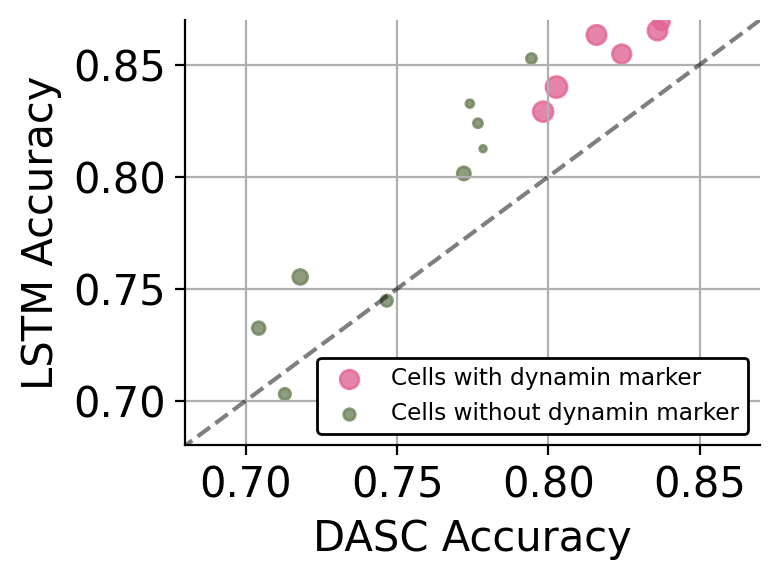

In [6]:
res = pd.read_csv(f"../reports/cell_level_res{suffix}.csv", index_col=0)
res = res[[c for c in res.columns if c.endswith('accuracy') and not 'balanced' in c]]
# res = res[[c for c in res.columns if c.endswith('accuracy') and not 'balanced' in c]]
dynamin_cells = [f'{k}_accuracy' for k in config.DSETS['clath_aux_dynamin']['test']]
non_dynamin_cells = [c for c in res.columns if c not in dynamin_cells]
baseline = 'svm_dasc'


plt.figure(dpi=200, figsize=(4, 3))
plt.grid(zorder=-1.0)
plt.scatter(res.loc[baseline][dynamin_cells].values, 
            res.loc['lstm'][dynamin_cells].values, 
            color='#E26595',
            s=[1. * num_cells[cell[:-9]]/30 for cell in dynamin_cells], 
            label='Cells with dynamin marker',
            alpha=.8)
plt.scatter(res.loc[baseline][non_dynamin_cells].values, 
            res.loc['lstm'][non_dynamin_cells].values, 
            color='#6F845C',
            s=[1. * num_cells[cell[:-9]]/30 for cell in non_dynamin_cells], 
            label='Cells without dynamin marker',
            alpha=.8)
plt.xlim((0.68, 0.87))
plt.ylim((0.68, 0.87))
plt.xlabel("DASC Accuracy")
plt.ylabel("LSTM Accuracy")
plt.legend(loc='lower right', fontsize='small', framealpha=1, edgecolor='black')
plt.plot((0.6, 0.95), (0.6, 0.95), '--', color='k', alpha=.5)
viz.savefig('acc_lstm_dasc')
plt.show()

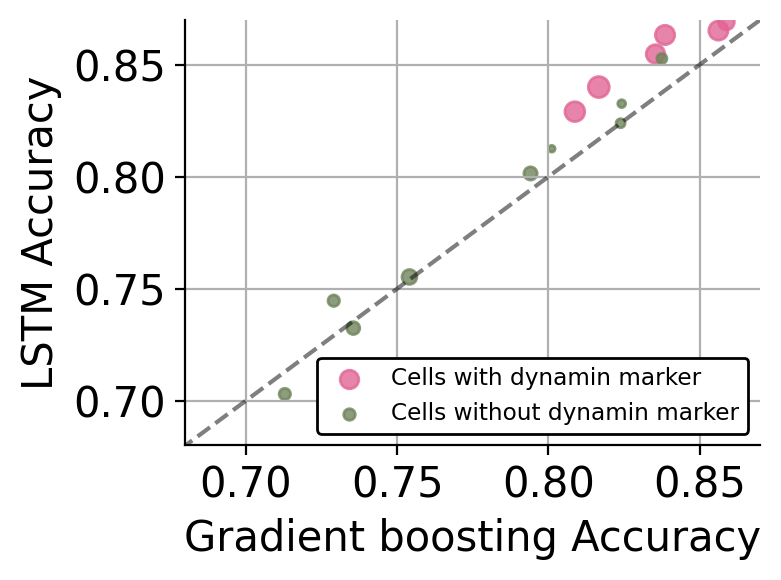

In [7]:
res = pd.read_csv(f"../reports/cell_level_res{suffix}.csv", index_col=0)
res = res[[c for c in res.columns if c.endswith('accuracy') and not 'balanced' in c]]
dynamin_cells = [f'{k}_accuracy' for k in config.DSETS['clath_aux_dynamin']['test']]
non_dynamin_cells = [c for c in res.columns if c not in dynamin_cells]
baseline = 'gb_basic'
plt.figure(dpi=200, figsize=(4, 3))
plt.grid(zorder=-10.0)
plt.scatter(res.loc[baseline][dynamin_cells].values, 
            res.loc['lstm'][dynamin_cells].values, 
            color='#E26595',
            s=[1. * num_cells[cell[:-9]]/30 for cell in dynamin_cells], 
            label='Cells with dynamin marker',
            alpha=.8)
plt.scatter(res.loc[baseline][non_dynamin_cells].values, 
            res.loc['lstm'][non_dynamin_cells].values, 
            color='#6F845C',
            s=[1. * num_cells[cell[:-9]]/30 for cell in non_dynamin_cells], 
            label='Cells without dynamin marker',
            alpha=.8)
#plt.figure(dpi=200, figsize=(4, 3))
#plt.scatter(res.loc['svm_dasc'].values, res.loc['lstm'].values, color='#E26595')
plt.xlim((0.68, 0.87))
plt.ylim((0.68, 0.87))
# plt.xticks([0.7, 0.75, 0.85])
# plt.yticks([0.7, 0.75, 0.85])
plt.xlabel("Gradient boosting Accuracy")
plt.ylabel("LSTM Accuracy")
plt.legend(loc='lower right', fontsize='small', framealpha=1, edgecolor='black')
# plt.title("Test accuracy", fontsize=15)

# plt.title("Classification accuracy", fontsize=15)
plt.plot((0.6, 0.95), (0.6, 0.95), '--', color='k', alpha=.5)
viz.savefig('acc_lstm_gb')
plt.show()

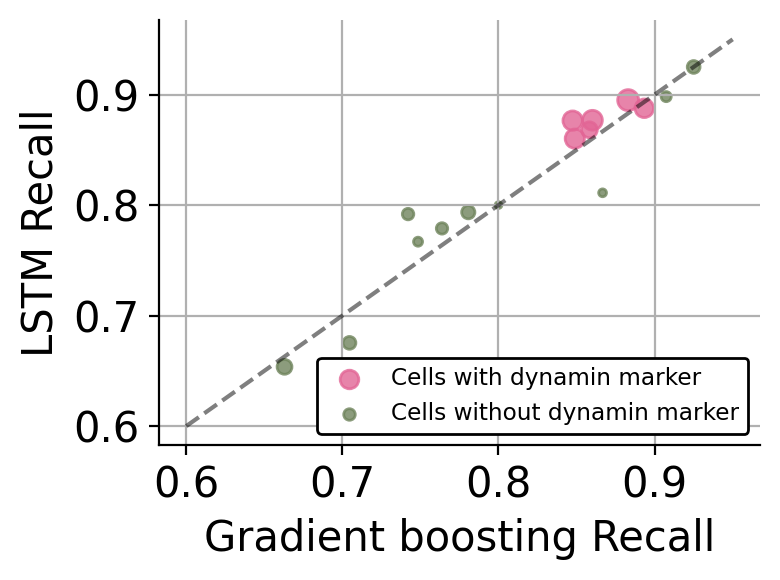

In [20]:
res = pd.read_csv(f"../reports/cell_level_res{suffix}.csv", index_col=0)
res = res[[c for c in res.columns if 'recall' in c]]
# print(res)
dynamin_cells = [f'{k}_recall' for k in config.DSETS['clath_aux_dynamin']['test']]
non_dynamin_cells = [c for c in res.columns if c not in dynamin_cells]
baseline = 'gb_basic'
plt.figure(dpi=200, figsize=(4, 3))
plt.grid(zorder=-10.0)
plt.scatter(res.loc[baseline][dynamin_cells].values, 
            res.loc['lstm'][dynamin_cells].values, 
            color='#E26595',
            s=[1. * num_cells[cell[:-7]]/30 for cell in dynamin_cells], 
            label='Cells with dynamin marker',
            alpha=.8)
plt.scatter(res.loc[baseline][non_dynamin_cells].values, 
            res.loc['lstm'][non_dynamin_cells].values, 
            color='#6F845C',
            s=[1. * num_cells[cell[:-7]]/30 for cell in non_dynamin_cells], 
            label='Cells without dynamin marker',
            alpha=.8)
#plt.figure(dpi=200, figsize=(4, 3))
#plt.scatter(res.loc['svm_dasc'].values, res.loc['lstm'].values, color='#E26595')
# plt.xlim((0.68, 0.87))
# plt.ylim((0.68, 0.87))
# plt.xticks([0.7, 0.75, 0.85])
# plt.yticks([0.7, 0.75, 0.85])
plt.xlabel("Gradient boosting Recall")
plt.ylabel("LSTM Recall")
plt.legend(loc='lower right', fontsize='small', framealpha=1, edgecolor='black')
# plt.title("Test accuracy", fontsize=15)

# plt.title("Classification accuracy", fontsize=15)
plt.plot((0.6, 0.95), (0.6, 0.95), '--', color='k', alpha=.5)
viz.savefig('recall_lstm_gb')
plt.show()